<a href="https://colab.research.google.com/github/NNRahat/PyTorch_projects/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

## device agnostic code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
import requests
import zipfile
from pathlib import Path

data_path = Path("Data")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} already exist...skipping download.")
else:
  print(f"{image_path} doesn't exist. creating one.....")
  image_path.mkdir(parents=True, exist_ok=True)

  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("downloading zip file........")
    f.write(request.content)

  # unzipping the zip file 
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("unzipping the zipfile.....")
    zip_ref.extractall(image_path)



Data/pizza_steak_sushi doesn't exist. creating one.....
downloading zip file........
unzipping the zipfile.....


## walk through directories

In [ ]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"there are {len(filenames)} images {len(dirnames)} directories in {dirpath}") 

In [ ]:
walk_through_dir(image_path)

there are 0 images 2 directories in Data/pizza_steak_sushi
there are 0 images 3 directories in Data/pizza_steak_sushi/train
there are 72 images 0 directories in Data/pizza_steak_sushi/train/sushi
there are 75 images 0 directories in Data/pizza_steak_sushi/train/steak
there are 78 images 0 directories in Data/pizza_steak_sushi/train/pizza
there are 0 images 3 directories in Data/pizza_steak_sushi/test
there are 31 images 0 directories in Data/pizza_steak_sushi/test/sushi
there are 19 images 0 directories in Data/pizza_steak_sushi/test/steak
there are 25 images 0 directories in Data/pizza_steak_sushi/test/pizza


In [ ]:
train_dir = image_path / "train"

test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('Data/pizza_steak_sushi/train'),
 PosixPath('Data/pizza_steak_sushi/test'))

image height: 512
image width: 512


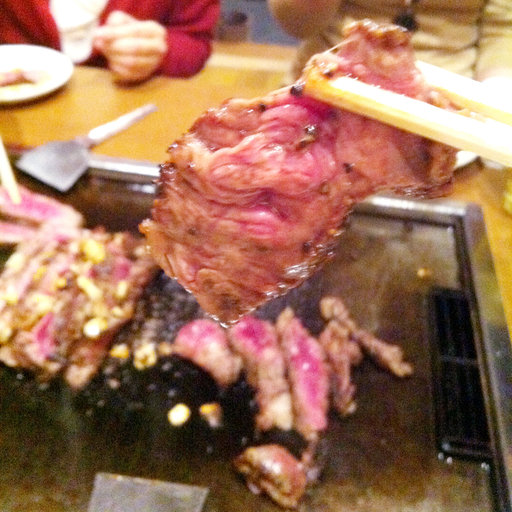

In [ ]:
from PIL import Image
import random

# random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"image height: {img.height}")
print(f"image width: {img.width}")

img

### with matplotlib

Its a pizza and the shape is (288, 512, 3)


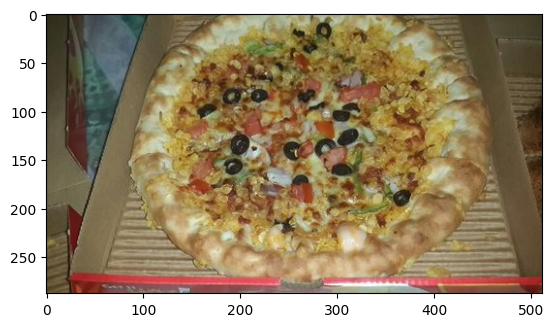

In [ ]:
import numpy as np

image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image = random.choice(image_path_list)
img = Image.open(random_image)
img_as_array = np.asarray(img)
plt.imshow(img_as_array)
print(f"Its a {random_image.parent.stem} and the shape is {img_as_array.shape}")
# random_image

### transforming data

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    # resize the image to 64 x 64
    transforms.Resize(size=(64, 64)),
    # flip the image horizontally on probability 0.5
    transforms.RandomHorizontalFlip(p=0.5),
    # convert the image into tensor
    transforms.ToTensor()
])

In [ ]:
data_transform(img).shape

torch.Size([3, 64, 64])

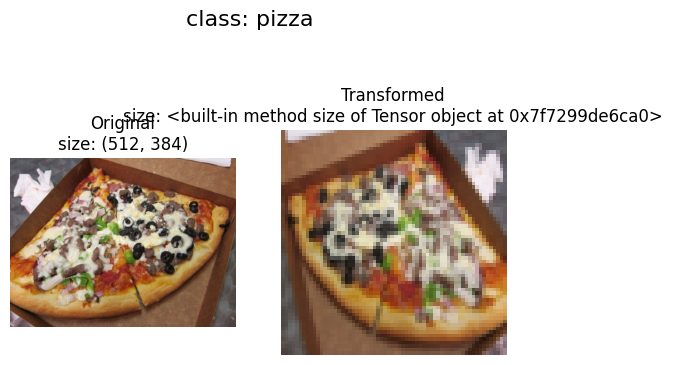

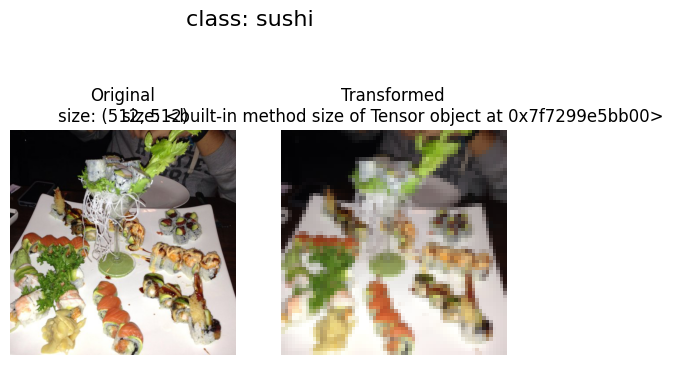

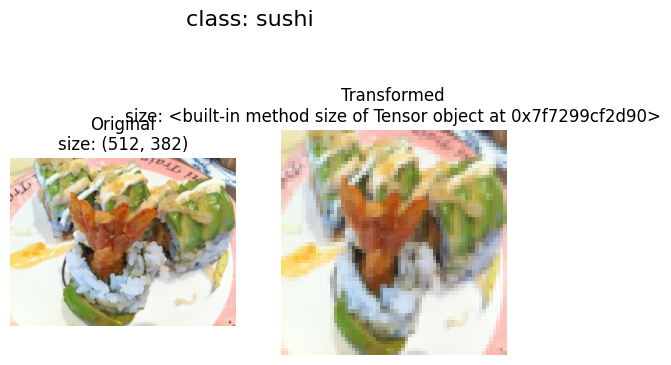

In [ ]:
def plot_transformed_image(image_path:list, transform, n=3, seed=None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_path, k=n)
  for image_path in random_image_paths:
    # for the actual image
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nsize: {f.size}")
      ax[0].axis(False)
    
      # for the transformed image
      transformed_image = transform(f).permute(1,2,0) # C X H X W -> H X W X C
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nsize: {transformed_image.size}")
      ax[1].axis(False)

      fig.suptitle(f"class: {image_path.parent.stem}", fontsize = 16)

plot_transformed_image(image_path = image_path_list,
                       transform = data_transform,
                       n=3,
                       seed = None)




In [ ]:
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: Data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: Data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
train_data.samples[0]

('Data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

###CPU cores for the parameters called `num_workers`

In [ ]:
print(f"total cpu cores :{os.cpu_count()}")

total cpu cores :2


In [ ]:
BATCH_SIZE = 10
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = 1,
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 1)
len(train_dataloader), len(test_dataloader)


(23, 8)

In [ ]:
img, label = next(iter(train_dataloader))
img.shape, label.shape

(torch.Size([10, 3, 64, 64]), torch.Size([10]))

In [ ]:
from typing import Tuple, List, Dict

In [ ]:
target_dir = train_dir

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  if not classes:
    return FileNotFoundError(f"could'n find any directories in {directory}...")
  
  class_to_idx = {class_name: i for i,class_name in enumerate(classes)}
  return classes, class_to_idx

In [ ]:
find_classes(target_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### augmentation

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor()
])

In [ ]:
image_path

PosixPath('Data/pizza_steak_sushi')

In [ ]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('Data/pizza_steak_sushi/train/sushi/1070104.jpg'),
 PosixPath('Data/pizza_steak_sushi/train/sushi/390178.jpg'),
 PosixPath('Data/pizza_steak_sushi/train/sushi/1571146.jpg'),
 PosixPath('Data/pizza_steak_sushi/train/sushi/2267190.jpg'),
 PosixPath('Data/pizza_steak_sushi/train/sushi/2175561.jpg'),
 PosixPath('Data/pizza_steak_sushi/train/sushi/17704.jpg'),
 PosixPath('Data/pizza_steak_sushi/train/sushi/3426958.jpg'),
 PosixPath('Data/pizza_steak_sushi/train/sushi/268990.jpg'),
 PosixPath('Data/pizza_steak_sushi/train/sushi/2674024.jpg'),
 PosixPath('Data/pizza_steak_sushi/train/sushi/2021381.jpg')]

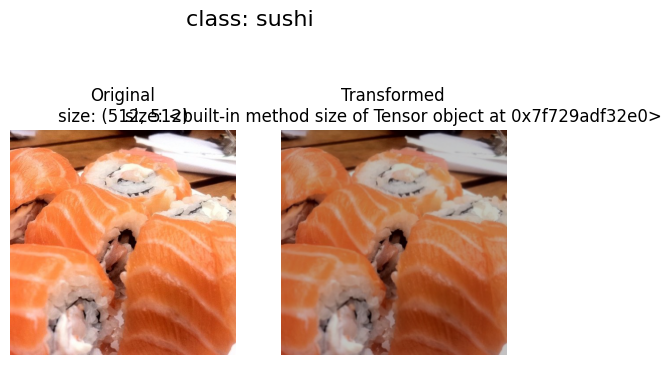

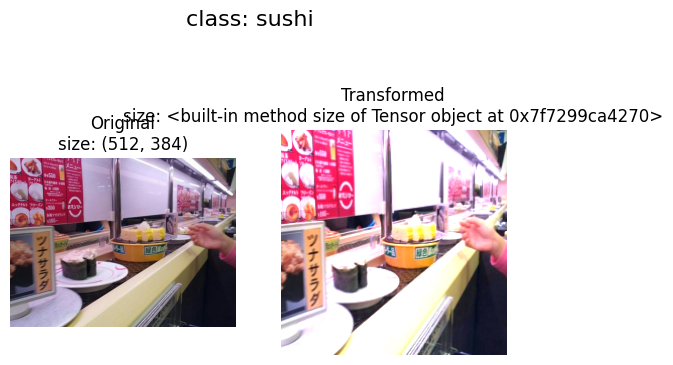

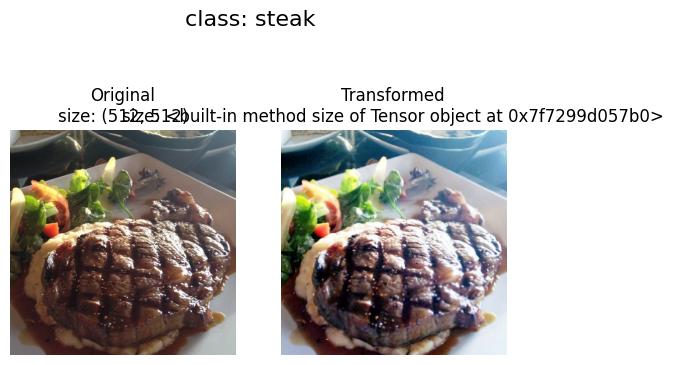

In [ ]:
plot_transformed_image(image_path = image_path_list,
                       transform = train_transform,
                       n = 3,
                       seed = 42)

## Some helper funtction

### helper function

In [ ]:
import requests 
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exist. Skipping!!!!!!!!!!")
else:
  print("downloading helper_functions.py!!!!")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

downloading helper_functions.py!!!!


### timer function

In [ ]:
from timeit import default_timer as timer
def print_time(start:int,
               end:int,
               device = device):
  total_time = end - start 
  print(f"Time on device: {device} took {total_time:.2f} secs")
  return total_time

## transform of data without augmentation

In [ ]:
transform_simple = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

In [ ]:
train_simple = datasets.ImageFolder(root = train_dir,
                                    transform = transform_simple)
test_simple = datasets.ImageFolder(root = test_dir,
                                   transform = transform_simple)
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset = train_simple,
                                     batch_size = BATCH_SIZE,
                                     num_workers = NUM_WORKERS,
                                     shuffle = True)
test_dataloader_simple = DataLoader(dataset = test_simple,
                                    batch_size = BATCH_SIZE,
                                    num_workers = NUM_WORKERS,
                                    shuffle = False)

### without augmentation class model

In [ ]:
class without_augmentation(nn.Module):
  def __init__(self, 
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_stack_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  padding = 0,
                  kernel_size = 3,
                  stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  padding = 0,
                  kernel_size = 3,
                  stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv_stack_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  padding = 0,
                  kernel_size = 3,
                  stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  padding = 0,
                  kernel_size = 3,
                  stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*13*13, 
                  out_features = output_shape)
    )
  def forward(self, x):
    # x = self.conv_stack_1(x)
    # print(x.shape)
    # x = self.conv_stack_2(x)
    # print(x.shape)
    # x = self.classifier(x)
    # print(x.shape)
    return self.classifier(self.conv_stack_2(self.conv_stack_1(x)))
  
model_0 = without_augmentation(input_shape = 3,
                               hidden_units = 10,
                               output_shape = len(class_names)).to(device)
  

### loss function and optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = model_0.parameters(),
                            lr = 0.001)

### train and test function creation

In [ ]:
from helper_functions import accuracy_fn
def train_steps(model: torch.nn.Module,
                dataloader: torch.utils.data,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim,
                accuracy_fn):
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X = X.to(device)
    y = y.to(device)
    
    train_logit = model(X)
    train_pred = torch.argmax(torch.softmax(train_logit, dim=1), dim=1)
    
    loss = loss_fn(train_logit, y)
    train_loss += loss.item()
    
    acc = accuracy_fn(y_true = y, y_pred = train_pred)
    train_acc += acc

    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
  
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  # print(f"Train loss: {train_loss} | train accuracy: {train_acc}%")
  return train_loss, train_acc
def test_steps(model: torch.nn.Module,
               dataloader: torch.utils.data,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in dataloader:
      
      X = X.to(device)
      y = y.to(device)
      
      test_logit = model(X)
      test_pred = torch.argmax(torch.softmax(test_logit, dim=1),dim=1)
      
      loss = loss_fn(test_logit, y)
      test_loss += loss.item()

      test_acc += accuracy_fn(y_true = y, y_pred = test_pred)

  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  # print(f"test loss:  {test_loss} | test accuracy: {test_acc}%")
  return test_loss, test_acc

###Train_test Function

In [ ]:
def train_test_func(model: torch.nn.Module,
                    train_dataloader: torch.utils.data.DataLoader,
                    test_dataloader: torch.utils.data.DataLoader,
                    loss_fn: torch.nn.Module,
                    optimizer: torch.optim,
                    accuracy_fn,
                    epochs:int = 5):
  from tqdm.auto import tqdm
  results = {"train_loss" : [],
             "train_acc" : [],
             "test_loss" : [],
             "test_acc" : [] }
  for epoch in tqdm(range(epochs)):
    print(f"\nEpoch: {epoch}\n------------------")
    
    train_loss, train_acc = train_steps(model = model,
                dataloader = train_dataloader,
                loss_fn = loss_fn,
                optimizer = optimizer,
                accuracy_fn = accuracy_fn)
    test_loss, test_acc = test_steps(model = model,
              dataloader = test_dataloader,
              loss_fn = loss_fn,
              accuracy_fn = accuracy_fn)
    
    print(f"Train loss: {train_loss}, Train accuracy: {train_acc}% | Test loss: {test_loss}, Test accuracy: {test_acc}%")
      
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

### train_test looping 


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time_on_gpu = timer()
NUM_EPOCH = 5

result_model_0 = train_test_func(model = model_0,
                                 train_dataloader = train_dataloader_simple,
                                 test_dataloader = test_dataloader_simple,
                                 loss_fn = loss_fn,
                                 optimizer = optimizer,
                                 accuracy_fn = accuracy_fn,
                                 epochs = NUM_EPOCH)
  
end_time_on_gpu = timer()
total_time = print_time(start = start_time_on_gpu,
                        end = end_time_on_gpu,
                        device = device)

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
------------------
Train loss: 1.1059762239456177, Train accuracy: 28.125% | Test loss: 1.0960489908854167, Test accuracy: 55.49242424242425%

Epoch: 1
------------------
Train loss: 1.0873597860336304, Train accuracy: 44.140625% | Test loss: 1.1113460461298625, Test accuracy: 26.041666666666668%

Epoch: 2
------------------
Train loss: 1.0749903097748756, Train accuracy: 42.578125% | Test loss: 1.1425641377766926, Test accuracy: 26.041666666666668%

Epoch: 3
------------------
Train loss: 1.0971617102622986, Train accuracy: 30.46875% | Test loss: 1.1443118453025818, Test accuracy: 27.083333333333332%

Epoch: 4
------------------
Train loss: 1.0717784464359283, Train accuracy: 42.96875% | Test loss: 1.091904838879903, Test accuracy: 34.375%
Time on device: cpu took 12.32 secs


In [ ]:
import pandas as pd
df = pd.DataFrame(result_model_0)
print(df)

   train_loss  train_acc  test_loss   test_acc
0    1.105976  28.125000   1.096049  55.492424
1    1.087360  44.140625   1.111346  26.041667
2    1.074990  42.578125   1.142564  26.041667
3    1.097162  30.468750   1.144312  27.083333
4    1.071778  42.968750   1.091905  34.375000


### torchinfo installation and import 

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size = (32,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
without_augmentation                     [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

###plot the curves of loss and accuracy

In [ ]:
from typing import Tuple,List,Dict
def plot_curves(results: Dict[str, list[float]]):
  train_loss = results["train_loss"]
  test_loss = results["test_loss"]

  train_acc = results["train_acc"]
  test_acc = results["test_acc"]


  epochs = range(len(results["train_loss"]))

  plt.figure(figsize = (15,7))

  plt.subplot(1,2,1)
  plt.plot(epochs, train_loss, label = "train loss")
  plt.plot(epochs, test_loss, label = "test_loss")
  plt.title("Loss")
  plt.xlabel("Epoch")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, train_acc, label="train accuracy")
  plt.plot(epochs, test_acc, label= "test accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epoch")
  plt.legend()

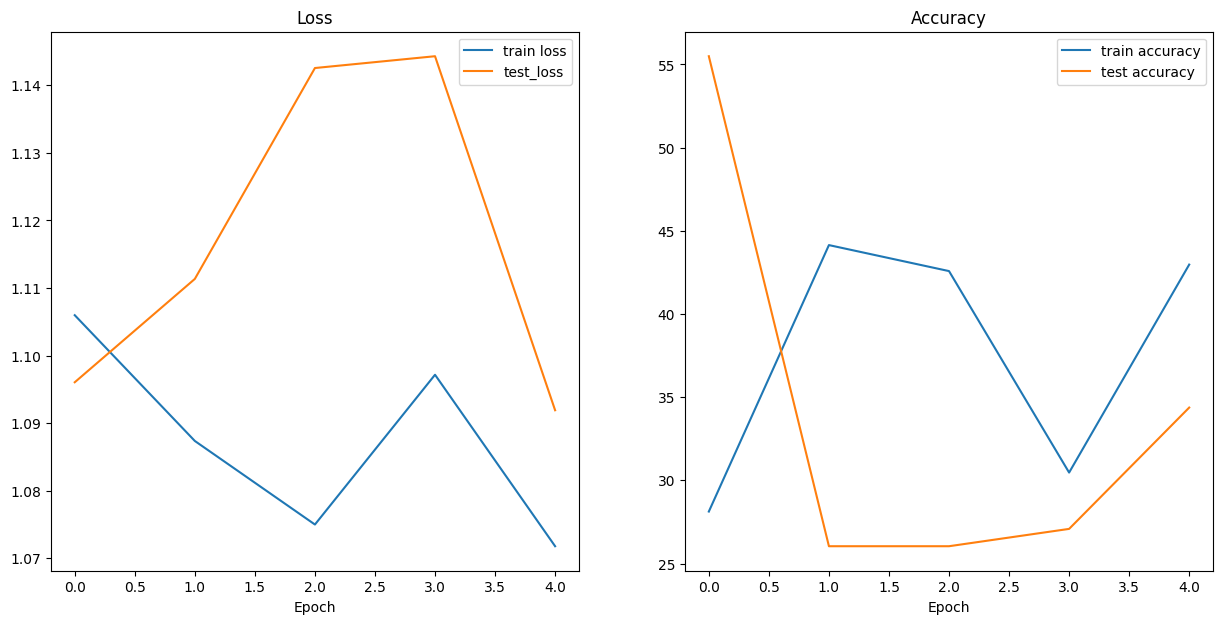

In [ ]:
plot_curves(result_model_0)

## with augmentation this time lets go

In [ ]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os

### device agnostic code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### directory in the making 

In [ ]:
import zipfile
from pathlib import Path
import requests

data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} already exist. Skipping download!!!!!!!")
else:
  print(f"{image_path} doesn't exist. Creating one!!!")
  image_path.mkdir(parents = True, exist_ok = True)

  with open("pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print(f"downloading the zip file to {data_path}")
    f.write(request.content)
  
  with zipfile.ZipFile("pizza_steak_sushi.zip") as zip_ref:
    print(f"extracting zip file to {image_path}")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi doesn't exist. Creating one!!!
downloading the zip file to data
extracting zip file to data/pizza_steak_sushi


### with just the `PIL`


height: 512
width: 512
Its a steak


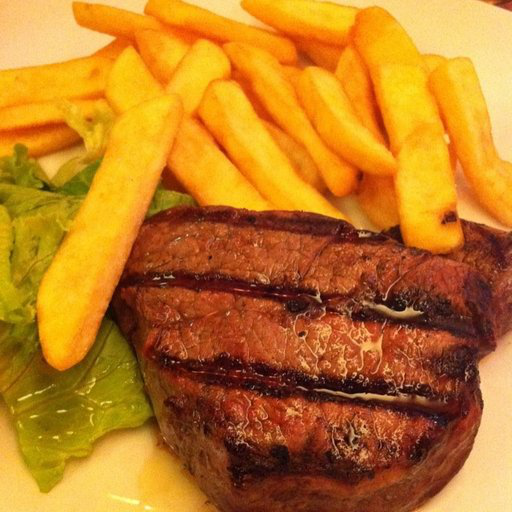

In [ ]:
from PIL import Image 
import random
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_img_path = random.choice(image_path_list)
image_classname = random_img_path.parent.stem
img = Image.open(random_img_path)

print(f"height: {img.height}")
print(f"width: {img.width}")
print(f"Its a {image_classname}")
img

### with `matplotlib.pyplot`

the shape of the image is (512, 512, 3)


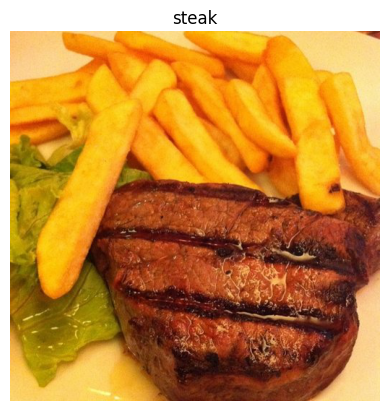

In [ ]:
image_as_array = np.asarray(img)
plt.imshow(image_as_array)
plt.title(f"{image_classname}")
plt.axis(False)
print(f"the shape of the image is {image_as_array.shape}")

In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins= 31),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

### time to cook some dataset with `imageFolder`

In [ ]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = train_transform,
                                  target_transform = None)
test_data = datasets.ImageFolder(root = test_dir,
                                 transform = test_transform)

### class names are 

In [ ]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

### datasets -> `datalaoder`

In [ ]:
from torch.utils.data import DataLoader 

BATCH_SIZE = 10
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = NUM_WORKERS)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = NUM_WORKERS)

### Model class creation

In [ ]:
from torch import nn
class with_augment_model(nn.Module):
  def __init__(self, 
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  padding = 1,
                  kernel_size = 3,
                  stride = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  padding = 1,
                  kernel_size = 3,
                  stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    ) 
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units, 
                  padding = 1,
                  kernel_size = 3,
                  stride = 1),
        nn.ReLU(),   
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  padding = 1,
                  kernel_size = 3,
                  stride = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*16*16,
                  out_features = output_shape)
    )

  def forward(self, x):   
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))


In [ ]:
model_1 = with_augment_model(input_shape = 3,
                             hidden_units = 10,
                             output_shape = len(class_names)).to(device)
model_1

with_augment_model(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### torchinfo installation and summary 

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_1, input_size = (32,3, 64, 64))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
with_augment_model                       [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

### loss function and optimizer 

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = model_1.parameters(),
                             lr = 0.001)

### train and test step creation

In [ ]:
def train_steps(model: torch.nn.Module,
                dataloader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim):
  model.train()
  train_loss, train_acc = 0, 0 
  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    train_logit = model(X)
    train_pred = torch.softmax(train_logit, dim=1).argmax(dim=1)

    loss = loss_fn(train_logit, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()
    
    train_acc += ((train_pred == y).sum().item() / len(train_pred))

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

def test_steps(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      test_logit = model(X) 
      test_pred_argonly = torch.argmax(test_logit, dim=1)
      test_pred = torch.softmax(test_logit, dim=1).argmax(dim=1)

      loss = loss_fn(test_logit, y)
      test_loss += loss.item()

      test_acc += ((test_pred == y).sum().item() / len(test_pred))

  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  return test_loss, test_acc

    

###train_test_func creation

In [ ]:
def train_test_func(model: torch.nn.Module,
                    train_dataloader: torch.utils.data.DataLoader,
                    test_dataloader: torch.utils.data.DataLoader,
                    loss_fn: torch.nn.Module,
                    optimizer: optimizer,
                    epochs:int = 5):
  from tqdm.auto import tqdm
  epochs = epochs

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    print(f"\nEpoch: {epoch}\n----------------")

    train_loss, train_acc = train_steps(model=model,
                                        dataloader = train_dataloader,
                                        loss_fn = loss_fn,
                                        optimizer = optimizer)
    test_loss, test_acc = test_steps(model = model,
                                     dataloader = test_dataloader,
                                     loss_fn = loss_fn)

    print(f"Train loss: {train_loss:.5f}, train accuracy: {train_acc:.3f} | test loss: {test_loss:.5f}, test accuracy: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  return results

### time for the real deal train and test looping (calling trian_test_func)

In [ ]:
from timeit import default_timer as timer

start_time = timer()

EPOCHS = 5

model_1_results = train_test_func(model = model_1,
                                  train_dataloader = train_dataloader,
                                  test_dataloader = test_dataloader,
                                  loss_fn = loss_fn,
                                  optimizer = optimizer,
                                  epochs = EPOCHS)

end_time = timer()
total_time = end_time - start_time
print(f"Time took to train the model: {total_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 0
----------------
Train loss: 1.10575, train accuracy: 0.317 | test loss: 1.09871, test accuracy: 0.3125

Epoch: 1
----------------
Train loss: 1.10057, train accuracy: 0.348 | test loss: 1.09907, test accuracy: 0.3125

Epoch: 2
----------------
Train loss: 1.09867, train accuracy: 0.339 | test loss: 1.10017, test accuracy: 0.3125

Epoch: 3
----------------
Train loss: 1.09835, train accuracy: 0.317 | test loss: 1.10163, test accuracy: 0.2625

Epoch: 4
----------------
Train loss: 1.09816, train accuracy: 0.343 | test loss: 1.10202, test accuracy: 0.3125
Time took to train the model: 10.368 seconds


### plot the curve again

In [ ]:
from typing import Tuple,List,Dict
def plot_curves(results: Dict[str, list[float]]):
  train_loss = results["train_loss"]
  test_loss = results["test_loss"]

  train_acc = results["train_acc"]
  test_acc = results["test_acc"]


  epochs = range(len(results["train_loss"]))

  plt.figure(figsize = (15,7))

  plt.subplot(1,2,1)
  plt.plot(epochs, train_loss, label = "train loss")
  plt.plot(epochs, test_loss, label = "test_loss")
  plt.title("Loss")
  plt.xlabel("Epoch")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, train_acc, label="train accuracy")
  plt.plot(epochs, test_acc, label= "test accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epoch")
  plt.legend()

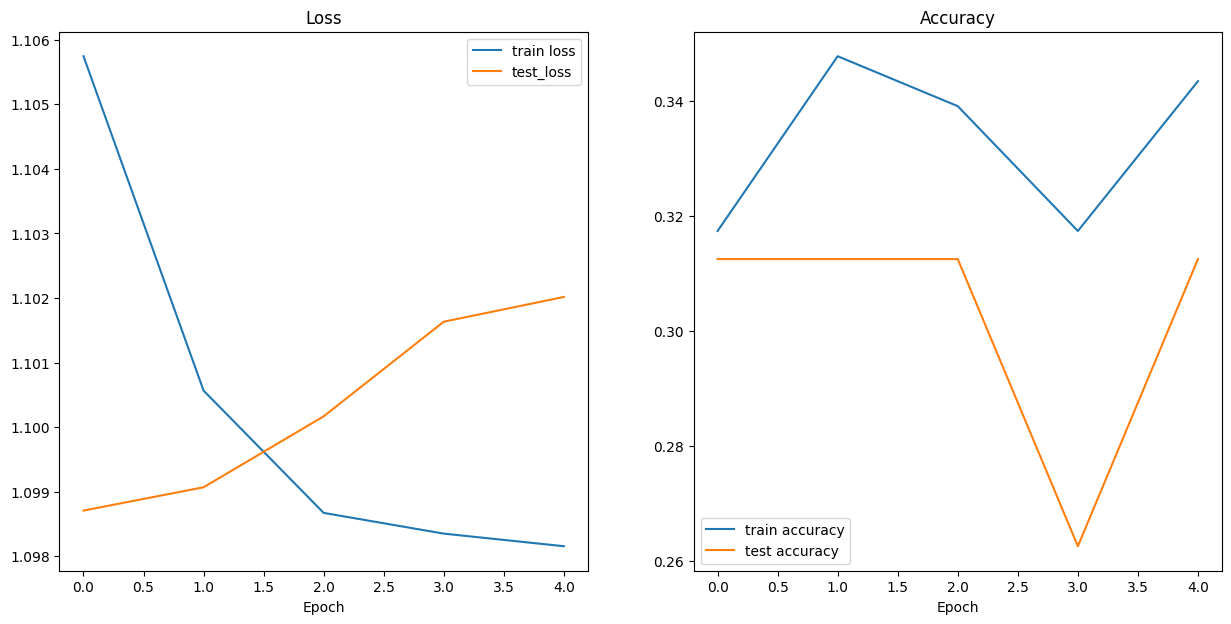

In [ ]:
plot_curves(model_1_results)

### DataFrames of model_0 and 1

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(result_model_0)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

NameError: ignored

In [ ]:
model_1_df

In [ ]:
model_0_train_loss = result_model_0["train_loss"]
model_0_train_acc = result_model_0["train_acc"]
model_0_test_loss = result_model_0["test_loss"]
model_0_test_acc = result_model_0["test_acc"]
model_1_train_loss = model_1_results["train_loss"]
model_1_train_acc = model_1_results["train_acc"]
model_1_test_loss = model_1_results["test_loss"]
model_1_test_acc = model_1_results["test_acc"]

epochs = 5

plt.figure(figsize = (15,7))
plt.subplot(2,2,1)
plt.plot(epochs, model_0_train_loss, label = "model_0")
plt.plot(epochs, model_1_train_loss, label = "model_1")
plt.title("train loss")
plt.xlabel("epoch")
plt.legend()

plt.subplot(2,2,2)
plt.plot(epochs, model_0_train_acc, label = "model_0")
plt.plot(epochs, model_1_train_acc, label = "model_1")
plt.title("train accuracy")
plt.xlabel("epoch")
plt.legend()


plt.subplot(2,2,3)
plt.plot(epochs, model_0_test_loss, label = "model_0")
plt.plot(epochs, model_1_test_loss, label = "model_1")
plt.title("test loss")
plt.xlabel("epoch")
plt.legend()


plt.subplot(2,2,4)
plt.plot(epochs, model_0_test_acc, label = "model_0")
plt.plot(epochs, model_1_test_acc, label = "model_1")
plt.title("test accuracy")
plt.xlabel("epoch")
plt.legend()



### custom image download

In [ ]:
custom_image_path = data_path / "pizza.jpg"

if Path(custom_image_path).is_file():
  print(f"{custom_image_path} already exist. Skipping download.............")
else:
  with open(custom_image_path,"wb") as f:
    request = requests.get("https://raw.githubusercontent.com/NNRahat/FRECIPE/main/images/pizza.jpg")
    print(f"downloading the image.Look at: {custom_image_path}")
    f.write(request.content)


In [ ]:
import torchvision
custom_image_path = data_path / "sushi-2.jpg"
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"custom image tensor: {custom_image_uint8}")
print(f"custom image shape: {custom_image_uint8.shape}")
print(f"custom image datatype: {custom_image_uint8.dtype}")

In [ ]:
plt.imshow(custom_image_uint8.permute(1,2,0))

#### custom image dtype `unit8` -> `float32`

In [ ]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

custom_image = custom_image / 255.

#### custom transform function

In [ ]:
custom_transform = transforms.Compose([
    transforms.Resize(size = (64, 64), antialias=True)
])

#### resizing the image with transform function

In [ ]:
custom_image = custom_transform(custom_image)
plt.imshow(custom_image.permute(1,2,0))

#### unsqueezing one dimention for the batch as it doesn't have that C X H X W -> B X C X H X W

In [ ]:
custom_image = custom_image.unsqueeze(dim=0)
custom_image.shape

#### to target device

In [ ]:
custom_image = custom_image.to(device)

In [ ]:
model_1.eval()
with torch.inference_mode():
  y_logit = model_1(custom_image)
  y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
plt.figure(figsize = (10,5))
plt.imshow(custom_image.cpu().squeeze().permute(1,2,0))
plt.title(f"Its {class_names[y_pred]}")
plt.axis(False)